<a href="https://colab.research.google.com/github/iLikeKatz/MyLeaning_ML/blob/main/PytorchFullCourse/Models/BinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [105]:
#amount of our samples data we need
n_samples = 1000

x, y = make_circles(n_samples, noise=0.03, random_state=42)


In [106]:
circles = pd.DataFrame({"x1" : x[:, 0],
                                    "x2" : x[:, 1],
                                    "label" : y})
circles

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


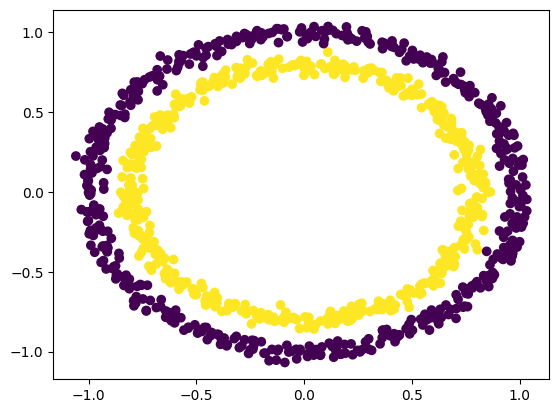

In [107]:
plt.scatter(x[:, 0], x[:, 1],c=y)
plt.show()

In [108]:
if type(y)  != torch.Tensor:
  x =  torch.from_numpy(x).type(torch.float)
  y  = torch.from_numpy(y).type(torch.float)
type(x), type(y), y.dtype

(torch.Tensor, torch.Tensor, torch.float32)

In [109]:
#split data
device = "cuda" if torch.cuda.is_available() else "cpu"
x = x.to(device)
y = y.to(device)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [110]:
#model
device = "cuda" if torch.cuda.is_available() else "cpu"

class CirclesModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer1 = nn.Linear(x.shape[1], 10) #it's 5 becaue we're going to change neurou from 2 to 5 for learning more patterns here
    self.linear_layer2 = nn.Linear(10, 10)
    self.linear_layer3 = nn.Linear(10, 1) #input gotta be same as output in previous layer and the final output here gotta be same as y
    self.relu = nn.ReLU() #because our model is non-linear so relu is very helpful, from i've tried, our model improved accuracy by double

  def forward(self, x):
    z = self.linear_layer1(x)
    z  = self.relu(z)
    z = self.linear_layer2(z)
    z = self.relu(z)
    z = self.linear_layer3(z)
    return z

model_0 = CirclesModel().to(device)
model_0

CirclesModel(
  (linear_layer1): Linear(in_features=2, out_features=10, bias=True)
  (linear_layer2): Linear(in_features=10, out_features=10, bias=True)
  (linear_layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [111]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

In [112]:
def accuracy_fn(y_pred, y_true):
  correct = torch.eq(y_pred, y_true).sum().item() #it's going to comparing each values and return true or false then .sum will sum whatever that's true += 1
  acc = (correct/len(y_pred)) * 100
  return acc

#testing the func
test1 = torch.tensor([1, 2, 3, 4])
test2 = torch.tensor([1, 2, 3, 5])
accuracy_fn(test1, test2)

75.0

In [113]:
torch.manual_seed(42)
epochs = 1000
loss_list = []
loss_test_list = []
epoch_list = []

for epoch in range(epochs):
  model_0.train()
  y_logits = model_0(x_train).squeeze() #ตัด dim ออก เพื่อให้เท่ากับ y_train เเละจะได้เทียบ loss ได้
  y_pred_train = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_pred_train, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    y_logits_test = model_0(x_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_logits_test))
    acc_test = accuracy_fn(y_pred_test, y_test)

    loss_test = loss_fn(y_logits_test, y_test)
    loss_list.append(loss.cpu())
    loss_test_list.append(loss_test.cpu())
    epoch_list.append(epoch)

    if epoch % 500 == 0 :
      print(f"epoch : {epoch}, loss train : {loss}, loss test : {loss_test}")


epoch : 0, loss train : 0.6929463148117065, loss test : 0.6920302510261536
epoch : 500, loss train : 0.002001262968406081, loss test : 0.008736779913306236


In [114]:
acc, acc_test

(100.0, 100.0)

In [115]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  pass
else :
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_function.py", "wb") as f:
    f.write(request.content)
  print("download completed")

from helper_function import plot_predictions, plot_decision_boundary

download completed


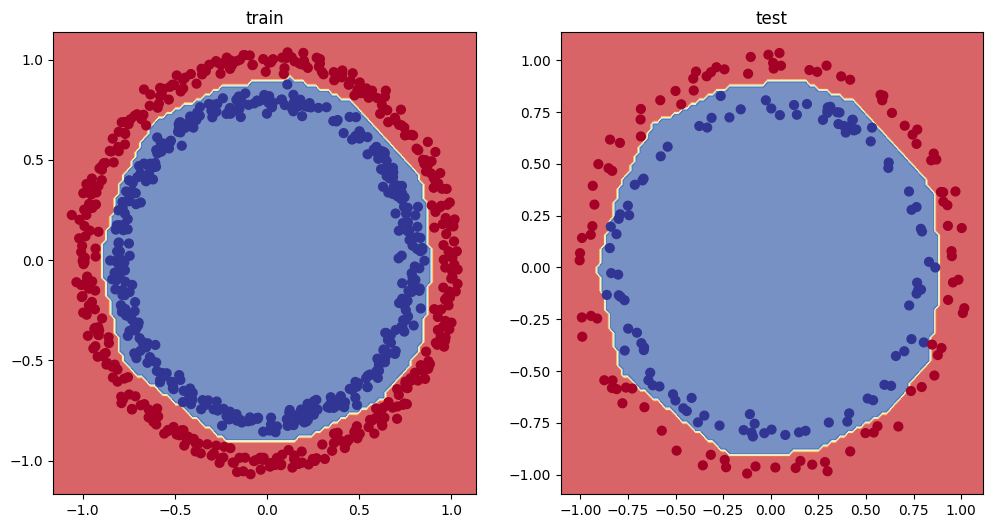

In [116]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1 ,2 ,2)
plt.title("test")
plot_decision_boundary(model_0, x_test, y_test)

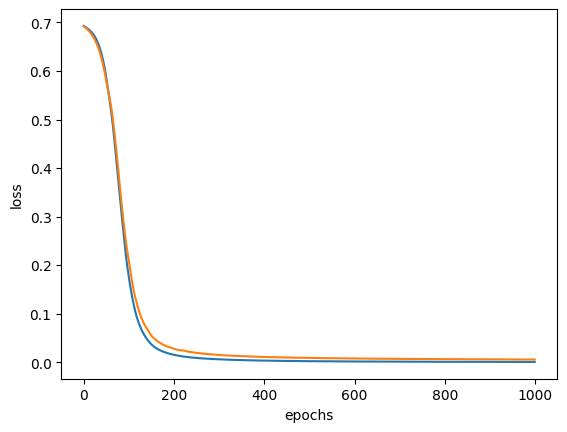

In [117]:
with torch.inference_mode():
  plt.plot(epoch_list, loss_list)
  plt.plot(epoch_list, loss_test_list)
  plt.xlabel("epochs")
  plt.ylabel("loss")
plt.show()

In [118]:
with torch.inference_mode():
  y_logits_ = model_0(x_test)
  y_pred = torch.round(torch.sigmoid(y_logits_)).squeeze()
  print(f"accuracy : {accuracy_fn(y_pred, y_test)}")

accuracy : 100.0


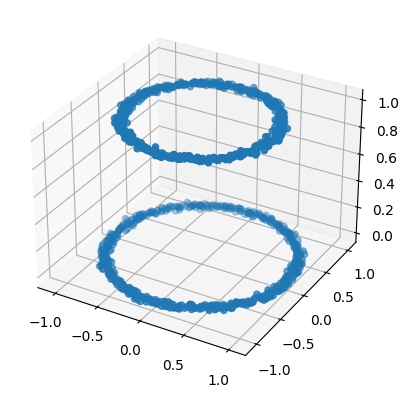

In [119]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], y)
plt.show()

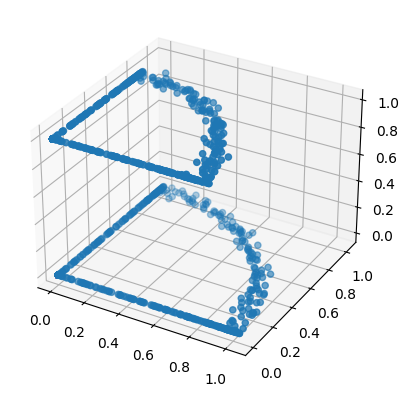

(tensor(1000), tensor(2000))

In [122]:
import torch.nn.functional as F
h = F.relu(x)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(h[:, 0], h[:, 1], y)
plt.show()

(x >= 0).sum(), (h>=0).sum() #as you'd see  after using relu, nothin values is less than zero
#this because relu's gone to adjust negative values to 0, so it's easier for model to learn patterns